<a href="https://colab.research.google.com/github/cperalta22/rplots/blob/main/ggplot2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

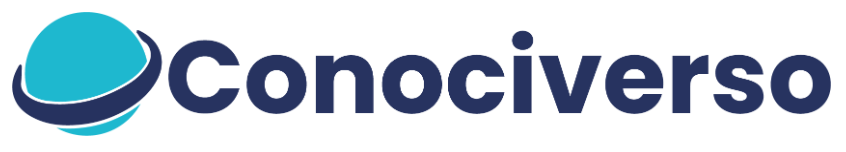


Carlos Alberto Peralta Alvarez 2025 | GPL3

## 📕 Importación de datos

### Instrucciones

*   Descarga e importa estos archivos a Colab
  * [luciferasas.csv](https://github.com/cperalta22/rplots/blob/main/luciferasas.csv)
  * [genes.csv](https://github.com/cperalta22/rplots/blob/main/genes.csv)
  * [expdiff.csv](https://github.com/cperalta22/rplots/blob/main/expdiff.tsv)

## ☝ Gráficos con `ggplot2`

`ggplot2` forma parte de `tidyverse` por lo que lo importaremos con `library()`

 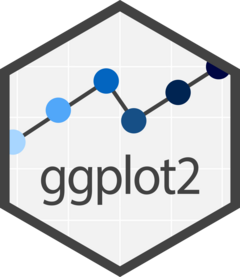

In [ ]:
library(tidyverse)

### 📑 Importemos las tablas a la sesión de R

In [ ]:
expdiff <- read_tsv("expdiff.tsv")
genes <- read_csv("genes.csv", col_names = F)
luciferasas <- read_csv("luciferasas.csv")

colnames(genes) <- c("cromosoma","inicio","final","gen")

### ☝Exploremos nuestros datos

In [ ]:
glimpse(expdiff)

In [ ]:
glimpse(luciferasas)

In [ ]:
glimpse(genes)

##  ☝ Procesamiento de los datos

###  ⚓ **Ejemplo 1** Calculemos señales normalizadas de luciferasa

#### Objetivo: obtener una visualización de las medias y su error de los valores normalizados y del cociente de las dos señales de luciferasa.

Si quieres ver el código completo da click [aqui](https://github.com/cperalta22/BBQ-long-range-expression-regulation/blob/main/Luciferases/luciferase_bbq.r)


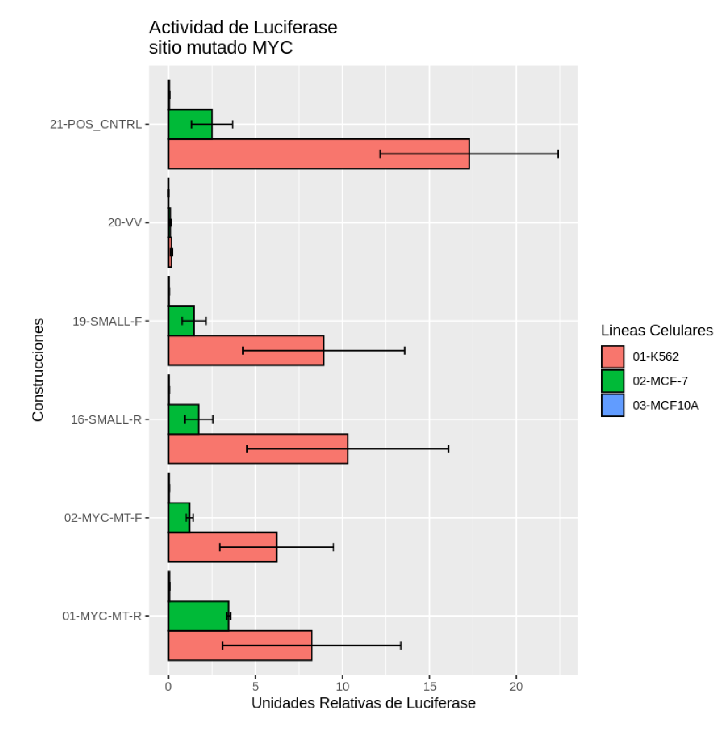

In [ ]:
luciferasas <- luciferasas |> mutate(luc_ratio = Luciferasa / Renilla)
head(luciferasas)
glimpse(luciferasas)

A nosotros lo que nos interesaría saber es la media del valor `luc_ratio` para cada elemento de tratando como un grupo independiente a todas las combinaciones de los valores de `Plasmido` y `Celula`

In [ ]:
lfs <- luciferasas |>
        group_by(Celulas, Plasmido) |>
        summarise(luc_ratio_sd = sd(luc_ratio, na.rm = T),
                  luc_ratio_media = mean(luc_ratio, na.rm = T),
                  .groups = "drop")

lfs
glimpse(lfs)

Eliminamos las combinaciones vacias y creamos un valor relativo que nos facilite mostrar valores muy distintos

In [ ]:
lfs <- filter(lfs, !is.nan(luc_ratio_media)) |>
        group_by(Celulas) |>
        mutate(rlu = luc_ratio_media / luc_ratio_media[Plasmido == "POS_CNTRL"]) |>
        ungroup()

# Ojo esto es sólo para visualizar, no lo estamos guardando en ningun lado
filter(lfs, Celulas == "MCF7")

###  ⚓ **Ejemplo 2** Creación de categorías para identificar visualmente datos

Usaremos una implementación de condicionales del `tidyverse` piensa en `case_when()` como un `if()` y `else` muy compacto

Primero determinaremos qué comparaciones son significativas o no

In [ ]:
expdiff <- expdiff |>
   mutate(significativo = case_when(
      abs(logFC) >= 1.5 & FDR < 0.005 ~ "Expresión diferencial",
      .default = "No significativo"
   ))

expdiff |> group_by(significativo) |> summarise(occurrencias = n(), logCPM_medio = mean(logCPM))

A continuación haremos categorias en función de la dirección del cambio

In [ ]:
expdiff <- expdiff |> mutate(direccion = case_when(
  significativo == "Expresión diferencial" & logFC < 0 ~ "Subexpresado",
  significativo == "Expresión diferencial" & logFC > 0 ~ "Sobreexpresado",
  .default = "No significativo"
))

expdiff |> group_by(direccion) |> summarise(ocurrencias = n(), logCPM_medio = mean(logCPM))

## ☝Componentes básicos de la función ggplot

* La función `ggplot()` y su contenido
  * `data` los datos con los que comenzamos, podemos omitirlo si lo pasamos con un pipe `|>`
  *  `mapping` dónde definimos los datos en particular que utilizaremos, los definiremos como los ejes `x` y `y`, dentro de la función de estética: `aes()` ahí también podremos definir otros parámetros visuales como colores, rellenos entre otros.
* Una función de geometría `geom_xxxxx()` dónde definiremos el tipo de gráfica que deseamos, en muchos casos podemos agregar parámetros estéticos adicionales nuevamente con la función `aes()`

In [ ]:
ggplot(data = expdiff, mapping = aes(x = direccion)) +
  geom_bar()

Podemos fácilmente agregar parámetros estéticos

In [ ]:
ggplot(expdiff, aes(x = direccion, fill = direccion)) +
  geom_bar()

## 🔥 Comparación contra R base

In [ ]:
luciferasas <- mutate(luciferasas, logluci = log(Luciferasa), logreni = log(Renilla))

In [ ]:
plot(luciferasas$logluci, luciferasas$logreni,
  type = "n",
)

points(luciferasas$logluci[luciferasas$Celulas == "K562"],
  luciferasas$logreni[luciferasas$Celulas == "K562"],
  pch = 15,
  col = "red"
)

points(luciferasas$logluci[luciferasas$Celulas == "MCF7"],
  luciferasas$logreni[luciferasas$Celulas == "MCF7"],
  pch = 17,
  col = "blue"
)

points(luciferasas$logluci[luciferasas$Celulas == "MCF10A"],
  luciferasas$logreni[luciferasas$Celulas == "MCF10A"],
  pch = 19,
  col = "darkgreen",
)

legend(x = "topleft",
  legend = c("K562","MCF7","MCF10A"),
  pch = c(15,17,19),
  col = c("blue", "darkgreen","red")
)


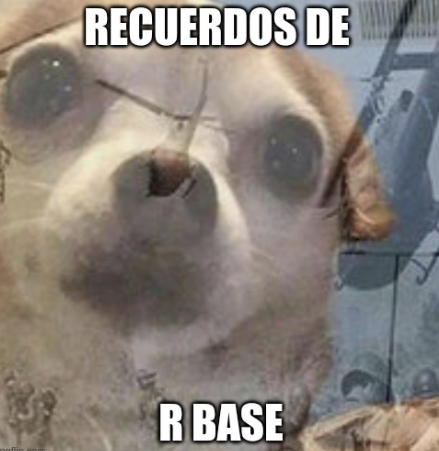

In [ ]:
ggplot(luciferasas, aes(x = log(Luciferasa), y= log(Renilla), color = Celulas, shape = Celulas)) +
  geom_point()

## ☝ Exploremos nuestros datos biológicos de manera visual con `ggplot2`

Obtengamos información rápida de la tabla de genes:

  * ¿Cuántas secuencias por cromosoma hay?
  * ¿Cuáles son los posibles valores de coordenadas por cada cromosoma?

In [ ]:
glimpse(genes)

In [ ]:
genes |> ggplot(aes(x = cromosoma)) +
          geom_bar()

In [ ]:
genes |> ggplot(aes(x = cromosoma, y = inicio, color = cromosoma ))+ geom_boxplot()

Debemos convertir a factores si necesitamos un órden específico de los datos

In [ ]:
genes |>
  mutate(cromosoma = factor(cromosoma, levels = c('chr1','chr2','chr3','chr4',
                                                  'chr5','chr6','chr7','chr8',
                                                  'chr9','chr10','chr11','chr12',
                                                  'chr13','chr14','chr15','chr16',
                                                  'chr17','chr18','chr19','chrX'))) |>
  ggplot(aes(x=cromosoma, y= inicio, color= cromosoma))+
      geom_boxplot(fill = "black")



In [ ]:
glimpse(genes)

## ☝ Las funciones para hacer tablas "largas" ó "anchas" nos pueden facilitar muchísimo la vida


In [ ]:
genes |> select(!gen) |> pivot_longer(!cromosoma, values_to = "coordenadas", names_to = "posicion") |> head()

In [ ]:
genes |> select(!gen) |>
      #mutate(inicio = inicio*4) |>
      pivot_longer(!cromosoma, values_to = "coordenadas", names_to = "posicion") |>
      ggplot(aes(x=cromosoma, y = coordenadas, fill = posicion, color = cromosoma )) + geom_boxplot()

In [ ]:
glimpse(expdiff)

In [ ]:
ggplot(expdiff, aes(x = direccion, y= logFC,fill = direccion)) +
  geom_boxplot()

In [ ]:
ggplot(data = expdiff, mapping = aes(x = significativo, y= FDR,fill = direccion)) +
  geom_boxplot()

In [ ]:
ggplot(data = expdiff, mapping = aes(x = significativo, y= log(FDR) ,fill = direccion)) +
  geom_boxplot()

In [ ]:
ggplot(data = expdiff, mapping = aes(x = significativo, y= log(FDR) ,fill = direccion)) +
  geom_boxplot() +
  ylim(c(-100,10))

## ☝ Hagamos un plot (casi) listo para ser publicado

### 🌋 Volcano plot



In [ ]:
ggplot(data = expdiff, mapping = aes(x = logFC, y= -log10(FDR))) +
  geom_point()

### 👸 Hagámoslo "bonito"

Agreguemos colores, titulos y líneas de referencia



In [ ]:
ggplot(data = expdiff, mapping = aes(x = logFC, y= -log10(FDR) ,color = direccion, shape = significativo)) +
  geom_point(size = 5) +
  ggtitle("Volcano plot de los cambios de expresión", subtitle = "DESeq2 Wild type vs Fármaco 1") +
  labs(caption = "Hecho con ggplot2!")+
  geom_vline(xintercept=-1.5, linetype = "dotted", color = "blue")+
  geom_vline(xintercept=1.5, linetype = "dotted", color = "darkgreen")+
  theme_classic()

### 📸 Guardemos el resultado

Con la función `pdf()` podemos guardar nuestro plot para la posteridad

**A diferencia de `R base` con `ggplot2` no podemos generar el plot dentro del bloque de código de `pdf()` por lo que es importante que guardemos nuestro plot como un objeto de R antes de seguir adelante**

```
pdf("titulo de mi plot.pdf",width = 8, height = 4) # dimensiones en pulgadas
objeto_con_nuestro_plot
dev.off() # con esto le decimos a R que ya terminamos de definir nuestro pdf
```

In [ ]:
miplot <- ggplot(data = tabla, mapping = aes(x = logFC, y= -log10(FDR) ,color = direccion, shape = significativo)) +
  geom_point(size = 5) +
  ggtitle("Volcano plot de los cambios de expresión", subtitle = "DESeq2 Wild type vs Fármaco 1") +
  labs(caption = "Hecho con ggplot2!")+
  geom_vline(xintercept=-1.5, linetype = "dotted", color = "blue")+
  geom_vline(xintercept=1.5, linetype = "dotted", color = "darkgreen")+
  theme_classic()

In [ ]:
pdf("Mi_fabuloso_plot_de_R.pdf", width = 5 , height = 5)
miplot
dev.off()

## ☝ Grafiquemos los resultados transformados de los ensayos de luciferasa

In [ ]:
glimpse(lfs)

In [ ]:
ggplot(lfs, aes(x = Celulas, y = rlu, fill = Celulas, color = Plasmido )) +
  geom_bar(stat= "identity", position =  "dodge")

In [ ]:
ggplot(lfs, aes(x = Celulas, y = luc_ratio_media, fill = Plasmido )) +
 geom_bar(stat= "identity", position =  "dodge") +
 geom_errorbar(aes(ymin=luc_ratio_media-luc_ratio_sd, ymax= luc_ratio_media+luc_ratio_sd), width=.2,
                 position=position_dodge(.9)) +
 theme_dark()

In [ ]:
lfs |> filter(Plasmido %in% c("POS_CNTRL", "VV", "SMALL-F", "LARGE-F")) |>
 ggplot(aes(x = Plasmido, y = luc_ratio_media, fill = Celulas )) +
 geom_bar(stat= "identity", position =  "dodge") +
 geom_errorbar(aes(ymin=luc_ratio_media-luc_ratio_sd, ymax= luc_ratio_media+luc_ratio_sd), width=.2,
                 position=position_dodge(.9)) +
 theme_light() +
 coord_flip()